In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("StudentsPerformance.csv")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [ ]:
df.shape

(1000, 8)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing    import OneHotEncoder
from sklearn.compose          import ColumnTransformer
from sklearn.pipeline         import Pipeline

# 1️⃣  Categorical columns (same as before)
cat_cols = [
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course"
]

# 2️⃣  Numeric columns we’re adding
num_cols = ["reading score", "writing score"]

# 3️⃣  Build X and y
X = df[cat_cols + num_cols]      # <-- now includes 7 features
y = df["math score"]

# 4️⃣  Train / test split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42)

# 5️⃣  Pre-processing: one-hot for cats, passthrough for nums
ohe = OneHotEncoder(drop='first', sparse_output=False)

preproc = ColumnTransformer(
    transformers=[
        ("cat", ohe,  cat_cols),     # one-hot encode categoricals
        # numeric cols are handled by “remainder='passthrough'”
    ],
    remainder='passthrough'
)


In [ ]:
from sklearn.linear_model    import LinearRegression
from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor

lin_reg = Pipeline([
    ("prep", preproc),
    ("model", LinearRegression())
])

dt_reg  = Pipeline([
    ("prep", preproc),
    ("model", DecisionTreeRegressor(random_state=42))
])

rf_reg  = Pipeline([
    ("prep", preproc),
    ("model", RandomForestRegressor(
                 n_estimators=400,
                 max_depth=None,
                 random_state=42))
])


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def eval_reg(model, name):
    y_pred = model.predict(X_test)
    print(f"—— {name} ——")
    print(" MAE :", round(mean_absolute_error(y_test, y_pred), 2))
    print(" RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))
    print(" R²  :", round(r2_score(y_test, y_pred), 3), "\n")

for mdl, name in [
        (lin_reg, "Linear Reg."),
        (dt_reg,  "Decision Tree"),
        (rf_reg,  "Random Forest")]:
    mdl.fit(X_train, y_train)
    eval_reg(mdl, name)


—— Linear Reg. ——
 MAE : 4.21
 RMSE: 5.39
 R²  : 0.88 

—— Decision Tree ——
 MAE : 6.41
 RMSE: 8.09
 R²  : 0.731 

—— Random Forest ——
 MAE : 4.69
 RMSE: 6.03
 R²  : 0.851 



In [ ]:
# Get one-hot encoded feature names
feat_names = rf_reg.named_steps["prep"].named_transformers_["cat"].get_feature_names_out(cat_cols)
all_features = list(feat_names) + num_cols  # add reading/writing scores

# Get importances
importances = rf_reg.named_steps["model"].feature_importances_
feature_importance = pd.Series(importances, index=all_features).sort_values(ascending=False)
feature_importance.head(10)


,0
reading score,0.561467
writing score,0.235659
gender_male,0.121011
lunch_standard,0.015791
test preparation course_none,0.011437
race/ethnicity_group E,0.010501
parental level of education_some college,0.007807
race/ethnicity_group C,0.007006
parental level of education_high school,0.006343
race/ethnicity_group D,0.006024


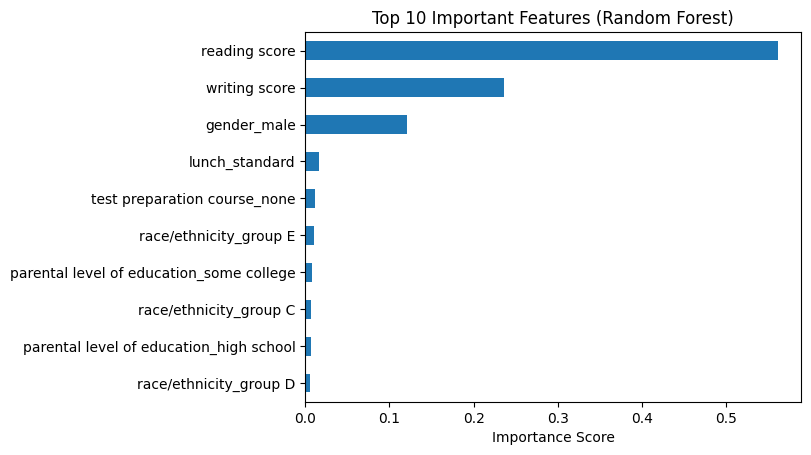

In [ ]:
import matplotlib.pyplot as plt

feature_importance.head(10).plot(kind='barh')
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
y_pred_lr = lin_reg.predict(X_test)
y_pred_dt = dt_reg.predict(X_test)
y_pred_rf = rf_reg.predict(X_test)


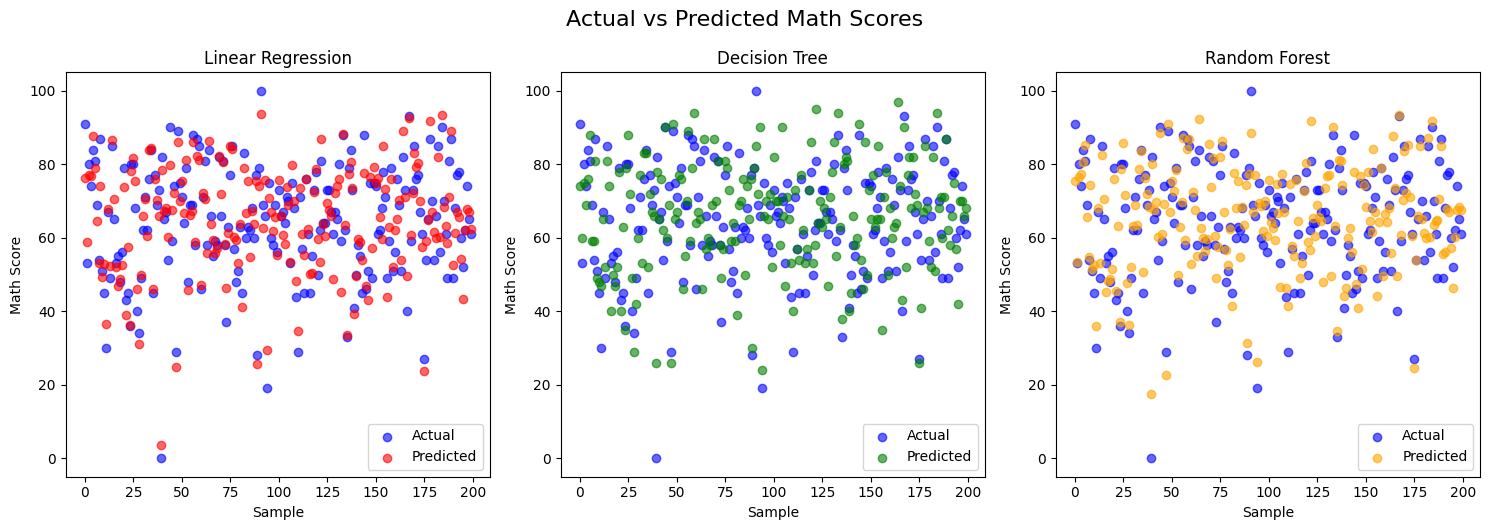

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Linear Regression
plt.subplot(1, 3, 1)
plt.scatter(range(len(y_test)), y_test, label="Actual", color='blue', alpha=0.6)
plt.scatter(range(len(y_test)), y_pred_lr, label="Predicted", color='red', alpha=0.6)
plt.title("Linear Regression")
plt.xlabel("Sample")
plt.ylabel("Math Score")
plt.legend()

# Decision Tree
plt.subplot(1, 3, 2)
plt.scatter(range(len(y_test)), y_test, label="Actual", color='blue', alpha=0.6)
plt.scatter(range(len(y_test)), y_pred_dt, label="Predicted", color='green', alpha=0.6)
plt.title("Decision Tree")
plt.xlabel("Sample")
plt.ylabel("Math Score")
plt.legend()

# Random Forest
plt.subplot(1, 3, 3)
plt.scatter(range(len(y_test)), y_test, label="Actual", color='blue', alpha=0.6)
plt.scatter(range(len(y_test)), y_pred_rf, label="Predicted", color='orange', alpha=0.6)
plt.title("Random Forest")
plt.xlabel("Sample")
plt.ylabel("Math Score")
plt.legend()

plt.tight_layout()
plt.suptitle("Actual vs Predicted Math Scores", fontsize=16, y=1.05)
plt.show()
